In [1]:
# import the main program and all the functions i created
from main import *

# Suppress warnings 
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
plt.style.use('fivethirtyeight')
#sns.set()
#pd.options.display.max_columns = 100

In [2]:
# Run once to generat the data / else: load data from the csv

# option 1
#data = main()

# option 2
data = pd.read_csv('main.csv')

In [4]:
data.head()
data.shape
type(data)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(307507, 797)

pandas.core.frame.DataFrame

In [4]:
missing_values = missing_values_table(data.copy())
missing_values

# free memory 
gc.enable()
del missing_values
gc.collect()

Your selected dataframe has 797 columns.
There are 616 columns that have missing values.


,Missing Values,% of Total Missing Values
REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MAX,262339,85.3
...,...,...
ANNUITY_INCOME_PERC,12,0.0
PAYMENT_RATE,12,0.0
CNT_FAM_MEMBERS,2,0.0
INCOME_PER_PERSON,2,0.0


0

In [110]:
# take some data
#data_cut = data
data_cut = data.sample(10_000).copy()
#data_cut = data_cut.astype('float64')

# replace all inifity values with maximum finite float64 values
data_cut.replace([np.inf, -np.inf], np.nan, inplace=True)

# free memory 
# gc.enable()
# del data
# gc.collect()

In [111]:
# fill NaN values with 0
data_cut.fillna(0,inplace=True)

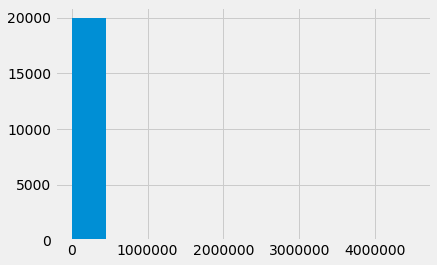

In [7]:
data_cut['INCOME_PER_PERSON'].hist()

In [8]:
# Process outliers
data_cut = outliers_transformer(data_cut)

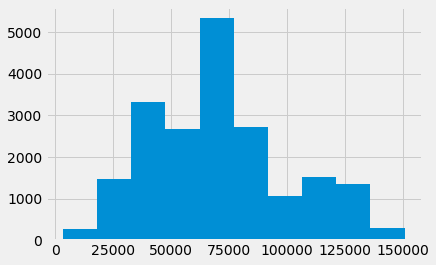

In [9]:
data_cut['INCOME_PER_PERSON'].hist()

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=6,n_estimators=50,n_jobs=-1)

X = data_cut.drop(['TARGET','SK_ID_CURR'], axis=1).copy()
y = data_cut['TARGET'].copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# convert NaN to 0 and inifite to maximum finite number

# Standardization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


rfc.fit(X_train_scaled, y_train)
print("train score:", rfc.score(X_train_scaled, y_train))
print("test score:", rfc.score(X_test_scaled, y_test))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

train score: 0.9203125
test score: 0.9205


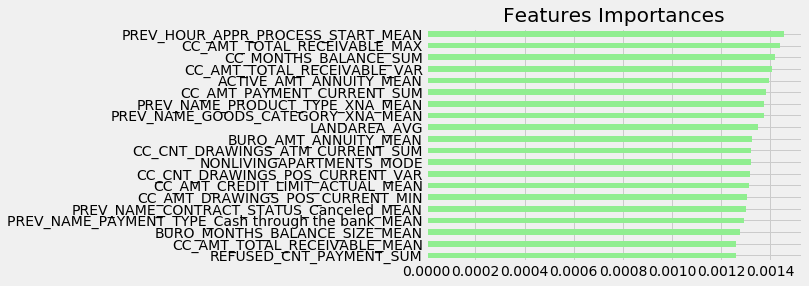

In [11]:
important_features = print_importance_features(rfc, X_train.columns)

In [93]:
positive_class = len(data_cut[data_cut['TARGET']==0])
negative_class = len(data_cut[data_cut['TARGET']==1])
xgboost_blance_param = positive_class/negative_class
xgboost_blance_param

11.106537530266344

In [159]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# #instantiate XGB Regressor
xgbr = xgb.XGBClassifier(eta=0.05,max_depth=6,min_child_weight=30,subsample=0.85,colsample_bylevel=0.632,colsample_bytree=0.7,nrounds=200,n_estimators=1000,n_jobs=-1,objective='binary:logistic',eval_metric='auc', scale_pos_weight=xgboost_blance_param, verbosity=1, gamma=0.1)


# xgbr = xgb.XGBClassifier(n_estimators=1000, objective='binary:logistic', gamma=0.1, subsample=0.5, scale_pos_weight=xgboost_blance_param,
#                             eta=0.05, max_depth=6, min )
#Hyper Parameter Optimization
params = {
    
    "nthread" : [4],
    "eta" : [0.05],
    "max_depth" : [6],
    "min_child_weight" :[ 30],
    "gamma" : [0],
    "subsample" :[ 0.85],
    "colsample_bytree" : [0.7],
    "colsample_bylevel" : [0.632],
    "alpha" : [0],
    "lambda" : [0],
    "nrounds" : [200]
          }
# params = {
#     'seed': [0],
#     'colsample_bytree': [0.7],
#     'silent': [1],
#     'subsample': [0.7],
#     'learning_rate': [0.075],
#     'objective': ['binary:logistic'],
#     'max_depth': [4],
#     'num_parallel_tree':[ 1],
#     'min_child_weight': [1],
#     'nrounds': [200]
# }

#random_search = GridSearchCV(xgbr,
                                #    param_grid=params,
                                #    scoring='roc_auc',
                                #    n_jobs=-1,cv=3,verbose=3)

In [160]:
# # Prepare data to run rhe model
X = data_cut.drop(['TARGET','SK_ID_CURR'],axis=1).copy()
y = data_cut['TARGET'].copy()



startify_param = data_cut['TARGET']
#split data into train,test (80,20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=startify_param)

# Standardization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgbr.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)

#random_search.fit(X_train_scaled,y_train)
# y_pred_test = random_search.predict(X_test_scaled)
# y_pred_train = random_search.predict(X_train_scaled)

# best_model = random_search.best_estimator_


[0]	validation_0-auc:0.65350
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.68785
[2]	validation_0-auc:0.72501
[3]	validation_0-auc:0.73838
[4]	validation_0-auc:0.74648
[5]	validation_0-auc:0.74101
[6]	validation_0-auc:0.74554
[7]	validation_0-auc:0.74733
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.75274
[10]	validation_0-auc:0.75466
[11]	validation_0-auc:0.75812
[12]	validation_0-auc:0.75993
[13]	validation_0-auc:0.76094
[14]	validation_0-auc:0.76254
[15]	validation_0-auc:0.76433
[16]	validation_0-auc:0.76670
[17]	validation_0-auc:0.77099
[18]	validation_0-auc:0.77221
[19]	validation_0-auc:0.77104
[20]	validation_0-auc:0.77185
[21]	validation_0-auc:0.77465
[22]	validation_0-auc:0.77599
[23]	validation_0-auc:0.77734
[24]	validation_0-auc:0.77508
[25]	validation_0-auc:0.77548
[26]	validation_0-auc:0.77496
[27]	validation_0-auc:0.77601
[28]	validation_0-auc:0.77498
[29]	validation_0-auc:0.77507
[30]	validation_0-auc:0.77477
[31]	validation_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.632,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.05,
              eval_metric='auc', gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.0500000007,
              max_delta_step=0, max_depth=6, min_child_weight=30, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              nrounds=200, num_parallel_tree=1, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=11.106537530266344, subsample=0.85,
              tree_method=None, validate_parameters=False, verbosity=1)

train score: 0.7435
test score: 0.758


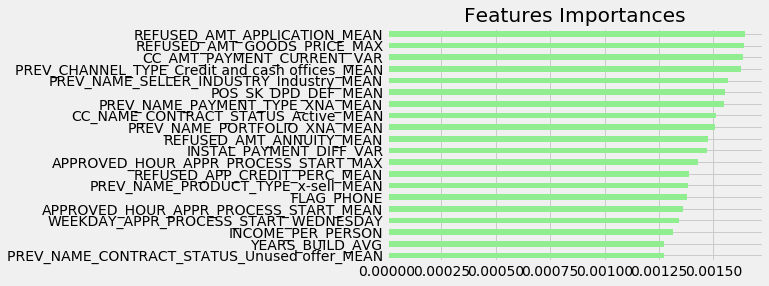

In [161]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import r2_score
print("train score:", accuracy_score(y_train,y_pred_train))
print("test score:", accuracy_score(y_test,y_pred_test))
important_features = print_importance_features(best_model, X_train.columns)

In [162]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test_scaled)
confusion_matrix(y_pred, y_test)
print ('Confusion Matrix :')
print(y_pred) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred)) 
print ('Report : ')
print (classification_report(y_test, y_pred))


array([[1570,   22],
       [ 257,  151]], dtype=int64)

Confusion Matrix :
[0 0 0 ... 0 0 0]
Accuracy Score : 0.8605
Report : 
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1827
           1       0.37      0.87      0.52       173

    accuracy                           0.86      2000
   macro avg       0.68      0.87      0.72      2000
weighted avg       0.93      0.86      0.88      2000



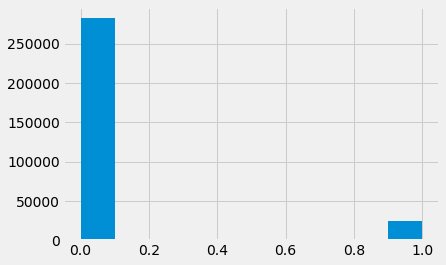

In [35]:
data['TARGET'].hist()

# serialize the model

In [15]:
# serialize the model
import pickle
pickle.dump(rfc, open('model.pkl', 'wb'))

## create some json files to test the api

In [16]:
X_test[:1].to_json('test_json_data.json')